In [1]:
from os.path import join,exists,realpath,dirname,basename
from os import makedirs,listdir, system
import numpy as np, cPickle, editdistance, seaborn as sns
import matplotlib.pyplot as plt, pandas as pd, itertools, glob, h5py
from scipy.stats import entropy
from matplotlib.font_manager import FontProperties
from IPython.display import display
from collections import defaultdict
from IPython.display import display
from itertools import izip
from scipy.stats import ranksums
import multiprocessing as mp
sns.set_style("whitegrid")
%matplotlib inline

In [12]:
rundir = '/cluster/zeng/code/research/OFTL-GAN/runs/motif_spikein_ATAGGC_50runs'

In [13]:
mapper = ['A','C','G','T']
re_mapper = {'A':0,'C':1,'G':2,'T':3}

In [14]:
def decode(data):
    mydict = ['A', 'C', 'G', 'T']
    out = []
    for x in data:
        out.append(''.join([mydict[np.argmax(y)] for y in x.squeeze().transpose()])) 
    return np.asarray(out)

def retrieve_bestrun_samples(pattern, use_abs=False):
    runs = glob.glob(pattern)
    bestloss = None
    bestrun = ''
    for run in runs:
        with open(join(run, 'history.pkl')) as f:
            history = cPickle.load(f)
        
        test_disc_loss = history['test']['discriminator']
        if type(test_disc_loss[0]) is not float and type(test_disc_loss[0]) is not np.float64:
            test_disc_loss = [x[0] for x in test_disc_loss]
        if use_abs:
            test_disc_loss = np.abs(test_disc_loss)
        t_argbest = np.argmin(test_disc_loss) 
        if bestloss is None or test_disc_loss[t_argbest] < bestloss:
            bestloss = test_disc_loss[t_argbest]
            bestrun = join(run, 'samples_epoch_{0:03d}_generated.pkl'.format(t_argbest))
    
    with open(bestrun) as f:
        best_sample = cPickle.load(f)
    return best_sample, bestrun, bestloss

def plot_acgt_distr(rundir, epoch_num, seqlen):
    
    all_distr = {'A':[], 'C':[], 'G':[], 'T':[]}
    for epoch in range(epoch_num):
        with open(join(rundir, 'samples_epoch_{0:03d}_generated.pkl'.format(epoch))) as f:
            sample = cPickle.load(f).squeeze().swapaxes(1,2)
        distr = defaultdict(int)
        for x in sample:
            for y in x:
                distr[mapper[y.argmax()]]+=1
        for x in ['A', 'C', 'G', 'T']:
            all_distr[x].append(distr[x]/float(len(sample)))
    for x in ['A', 'C', 'G', 'T']:
        plt.plot(range(epoch_num), all_distr[x], label=x)
    plt.legend()
        
def data2prob(data_ori,idx_mapper):
    # Calcualte the emperical kmer distribution from a generated dataset
    out = np.zeros(len(idx_mapper.keys()))
    data = data_ori.squeeze().swapaxes(1,2)
    for x in data:
        t_data = [ mapper[y.argmax()]   for y in x]
        out[idx_mapper[''.join(t_data)]] += 1
    return out/sum(out)

def kl_prepare(motif_file, seqlen):
    # All posible kmers
    candidate = [''.join(p) for p in itertools.product(mapper, repeat=seqlen)]

    # Map each kmer to its index in the list
    idx_mapper = dict()
    for idx,x in enumerate(candidate):
        idx_mapper[x] = idx

    # Read the motif
    with open(motif_file) as f:
        f.readline()
        motif_mat = [map(float,x.split()) for x in f]

    # Calculate the expected probability of each kmer
    design_p = np.zeros(len(candidate))
    for idx,x in enumerate(candidate):
        t_p = 1.0
        for cidx, c in enumerate(list(x)):
            t_p *= motif_mat[cidx][re_mapper[c]]
        design_p[idx] = t_p
    return idx_mapper, design_p

def kl_compare(samples, idx_mapper, design_p):
    pred_p = data2prob(samples, idx_mapper)
    return entropy(pred_p, design_p) - entropy(pred_p, pred_p) 

def comparePWM(samples, motif_file, seqlen, ):
    # Read the motif
    with open(motif_file) as f:
        f.readline()
        motif_mat = [map(float,x.split()) for x in f]
    
    empirical = np.zeros((seqlen, 4))
    mydict = {'A':0, 'C':1, 'G':2, 'T':3}
    print 1
    for s in samples:
        t_s = np.copy(s).squeeze().transpose()
        for pos, c in enumerate(t_s):
            empirical[pos][np.argmax(c)] += 1
    print 2
    for i in range(seqlen):
        empirical[i] /= sum(empirical[i])
    
    diff = empirical - motif_mat
    sns.heatmap(diff)
    plt.show()

In [15]:
dataset = ''
motif_file = join(rundir, '../../data/motifs/ATAGGC.pwm')
motif_len = 6

In [28]:
versions = ['1', '2' , '3']
schedules = ['None', 'adagrad', 'nesterov0.9', 'momentum0.9', 'adam']
optimizers = ['OMDA', 'SGD', 'optimAdam']
network = 'wgan'
ginters = [1, 5]
lrs = ['5e-02', '5e-03', '5e-04']
n_epoch = 100

In [17]:
rename_dict = {'SOMDv1':'SOMD_ver1',
               'SOMDv2':'SOMD_ver2',
               'SOMDv3':'SOMD_ver3',
               'SGD':'SGD_vanilla',
               'adagrad':'SGD_adagrad',
               'nesterov':'SGD_nesterov',
               'momentum':'SGD_momentum',
               'SOMDv1_ratio1':'SOMD_ver1_ratio1',
               'SOMDv2_ratio1':'SOMD_ver2_ratio1',
               'SOMDv3_ratio1':'SOMD_ver3_ratio1',
               'adam':'SGD_adam',
               'optimAdam':'optimAdam',
               'optimAdam_ratio1':'optimAdam_ratio1',}

#### Compare the performance of the iteration with the lowest test loss

In [18]:
pattern = join(rundir, 'runRUN', 'OPTIMIZER_SCHEDULE_vVERSION_lr*_NETWORK_ginterGINTER_gp1e-4')
idx_mapper, design_p = kl_prepare(motif_file, motif_len)
args = []
params = []
for run in range(50):
    for optimizer in optimizers:
        versions2use = versions if optimizer == 'OMDA' else ['0']
        for version in versions2use:
            schedule2use = schedules if optimizer  == 'SGD' else ['None']
            ginter2use = ginters if optimizer != 'SGD' else [5]
            for ginter in ginter2use:
                for schedule in schedule2use:
                    t_pattern = pattern.replace('OPTIMIZER', optimizer)
                    t_pattern = t_pattern.replace('SCHEDULE', schedule)
                    t_pattern = t_pattern.replace('VERSION', version)
                    t_pattern = t_pattern.replace('NETWORK', network)
                    t_pattern = t_pattern.replace('GINTER', str(ginter))
                    t_pattern = t_pattern.replace('RUN', str(run)) 
                    #t_pattern = t_pattern.replace('LR', str(lrs[0])) 
                    barcode = '_'.join([optimizer, version, schedule, str(ginter)])
                    args.append([t_pattern, idx_mapper, design_p])
                    params.append([optimizer, version, schedule, run, barcode])


In [19]:
def lowest_loss_slave(args):
    t_pattern, idx_mapper, design_p = args[:]
    best_sample, bestrun, bestloss = retrieve_bestrun_samples(t_pattern)
    return kl_compare(best_sample, idx_mapper, design_p)

In [20]:
pool = mp.Pool(processes=16)
all_kl=pool.map(lowest_loss_slave, args)
pool.close()
pool.join()

bestval_perform = []
for param, kl in izip(params, all_kl):
    bestval_perform.append(param + [kl])

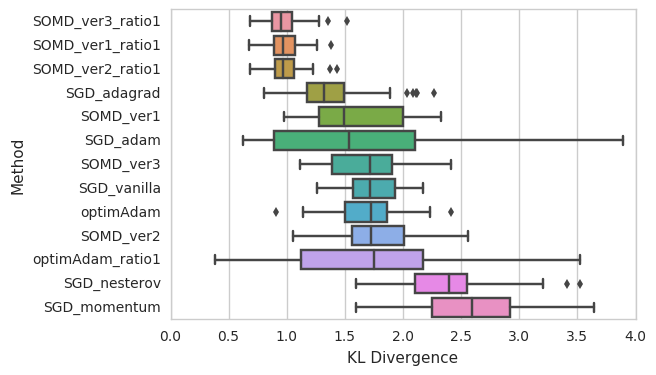

In [35]:
df = pd.DataFrame(bestval_perform, columns=['optimizer', 'version', 'schedule', 'run', 'method',  'KL'])

df_rename = pd.DataFrame()
df_rename['KL Divergence'] = df['KL']
df_rename['Method'] = [rename_dict[x] for x in df['method']]

median_df = pd.DataFrame()
median_df['Median KL'] = [np.median(df_rename[df_rename['Method']==m]['KL Divergence']) 
                          for m in np.unique(df_rename['Method'])]
median_df['Method'] = np.unique(df_rename['Method'])

ax=sns.boxplot(x='KL Divergence', y='Method', data=df_rename, order=median_df.sort_values('Median KL')['Method'])
ax.get_figure().savefig('experimental_lowestval.eps',bbox_inches='tight')

#### Compare the performance of the last iteration

In [29]:
pattern = join(rundir, 'runRUN', 'OPTIMIZER_SCHEDULE_vVERSION_lrLR_NETWORK_ginterGINTER_gp1e-4')
idx_mapper, design_p = kl_prepare(motif_file, motif_len)
args = []
params = []
for run in range(50):
    for optimizer in optimizers:
        versions2use = versions if optimizer =='OMDA' else ['0']
        for version in versions2use:
            schedule2use = schedules if optimizer  == 'SGD' else ['None']
            ginter2use = ginters if optimizer != 'SGD' else [5]
            for ginter in ginter2use:
                for schedule in schedule2use:
                    for lr in lrs:
                        t_pattern = pattern.replace('OPTIMIZER', optimizer)
                        t_pattern = t_pattern.replace('SCHEDULE', schedule)
                        t_pattern = t_pattern.replace('VERSION', version)
                        t_pattern = t_pattern.replace('NETWORK', network)
                        t_pattern = t_pattern.replace('GINTER', str(ginter))
                        t_pattern = t_pattern.replace('LR', lr)
                        t_pattern = t_pattern.replace('RUN', str(run))

                        barcode = '_'.join([optimizer, version, schedule, str(ginter), lr])
                        args.append([t_pattern, idx_mapper, design_p])
                        params.append([optimizer, version, schedule, run, barcode])

In [30]:
def last_slave(args):
    t_pattern, idx_mapper, design_p = args[:]
    lastrun = join(t_pattern, 'samples_epoch_{0:03d}_generated.pkl'.format(n_epoch-1))
    with open(lastrun) as f:
        last_sample = cPickle.load(f)
    return kl_compare(last_sample, idx_mapper, design_p)

In [31]:
pool = mp.Pool(processes=16)
all_kl=pool.map(last_slave, args)
pool.close()
pool.join()

lastiter_perform = []
for param, kl in izip(params, all_kl):
    lastiter_perform.append(param + [kl])

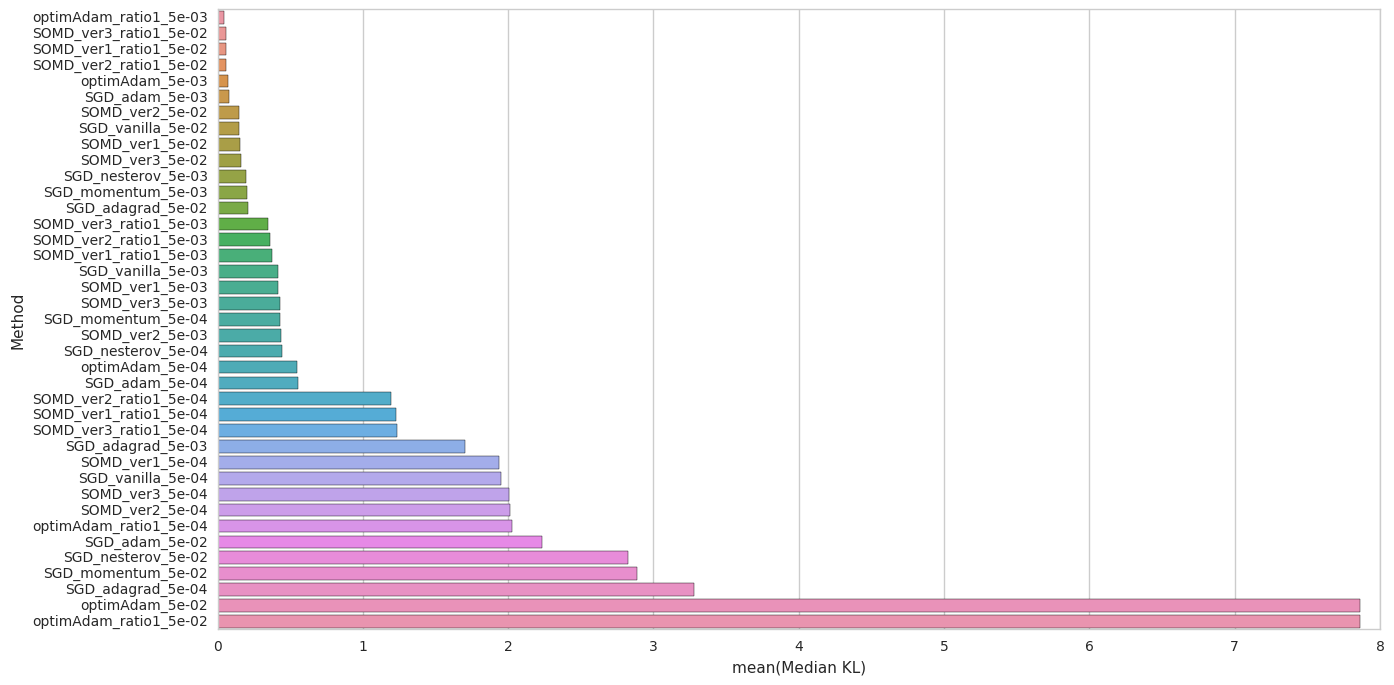

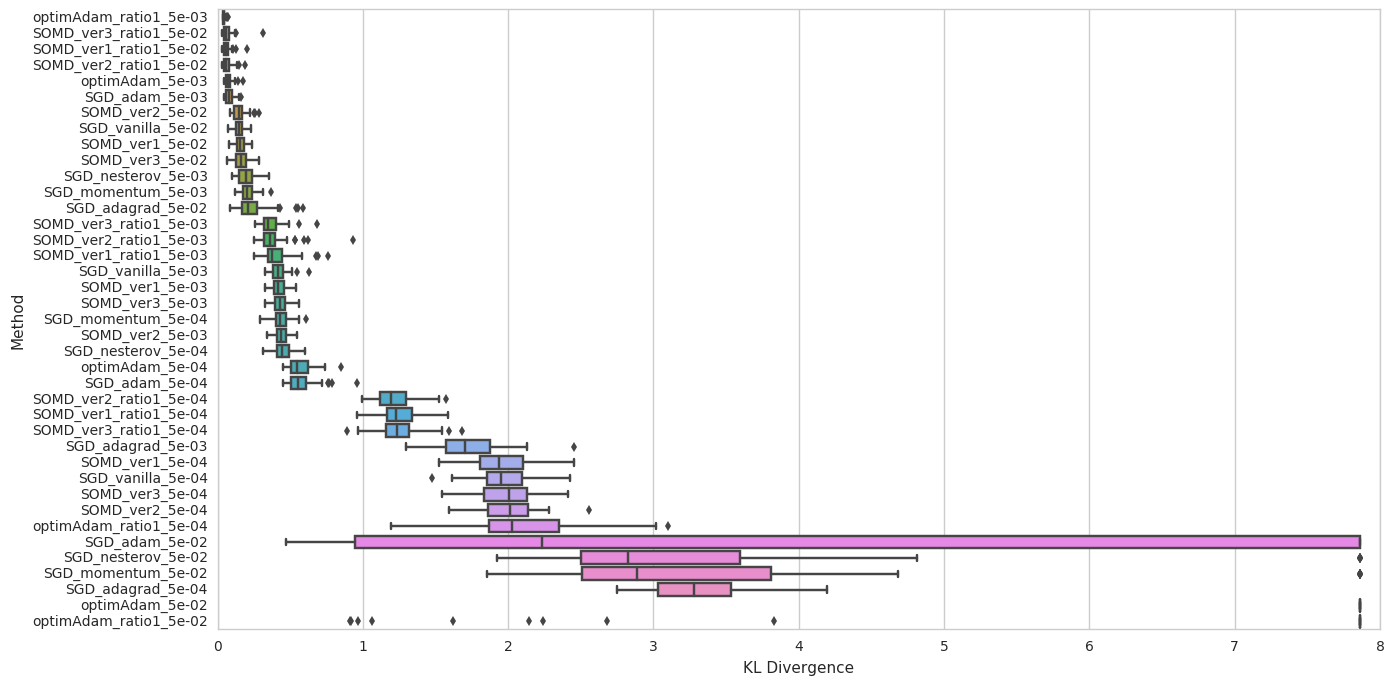

In [32]:
df = pd.DataFrame(lastiter_perform, columns=['optimizer', 'version', 'schedule', 'run', 'method',  'KL'])
df_rename = pd.DataFrame()
df_rename['KL Divergence'] = df['KL']
df_rename['Method'] = [rename_dict['_'.join(x.split('_')[:-1])]+'_'+x.split('_')[-1] for x in df['method']]

median_df = pd.DataFrame()
median_df['Median KL'] = [np.median(df_rename[df_rename['Method']==m]['KL Divergence']) 
                          for m in np.unique(df_rename['Method'])]
median_df['Method'] = np.unique(df_rename['Method'])
plt.figure(figsize=(15,8))
sns.barplot(y='Method', x='Median KL',data=median_df.sort_values('Median KL'))
plt.show()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x='KL Divergence', y='Method', data=df_rename, order=median_df.sort_values('Median KL')['Method'])
ax.get_figure().savefig('experimental_lastepoch.eps', bbox_inches='tight')
plt.show()